# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
import glob
import numpy as np
from nltk import FreqDist
import string

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(i) for i in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        c = Counter(tokens)
        top_five = c.most_common(5)
        top_five_df = pd.DataFrame(top_five, columns= ['Token', 'Count'])
        print("\nFive Most Common Tokens: \n\n", top_five_df)

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(text, sw=sw) :
    # modify this function to remove stopwords
    return([ch for ch in text if ch not in sw])


def remove_punctuation(text, punct_set=tw_punct) : 
   text = [''.join(ch for ch in word if ch not in punct_set)
           for word in text]
   
   return(text)


def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    text = text.strip().split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/HunterBlum/OneDrive/School/SanDiego/Courses/Text/TextMining_HBlum/data/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here
# Read in the lyrics data
# Get the filepaths for our artists
artists = ["beatles", "ledzeppelin"]
lyrics_filepaths = []
artist_list = []

for i in artists:

    # Create the file path for each artist
    path = data_location + lyrics_folder + i

    # Get the files
    txt_files = glob.glob(os.path.normpath(os.path.join(path, "*.txt")))

    # Create artist list we'll need for df
    temp_list = [i] * len(txt_files)
    artist_list = artist_list + temp_list

    # Join the filepaths from different artists
    lyrics_filepaths = lyrics_filepaths + txt_files

    


lyrics_list = []
song_list = []


for file in lyrics_filepaths:

    # Get the song title
    file_temp = open(file, "r")
    title = file_temp.readline().rstrip()
    song_list.append(title)

    # Get the lyrics
    list = file_temp.readlines()[1:]
    lyrics = "".join(list)
    lyrics = lyrics.replace('\n', " ")
    lyrics_list.append(lyrics)
    file_temp.close()

# Convert to df
dict = {'artist': artist_list, 'song': song_list, 'lyrics': lyrics_list}
lyrics_data = pd.DataFrame(dict)

lyrics_data.head()

,artist,song,lyrics
0,beatles,"""All I've Got To Do""","Whenever I want you around, yeah All I gott..."
1,beatles,"""All My Loving""",Close your eyes and I'll kiss you Tomorrow ...
2,beatles,"""Anna (Go To Him)""","Anna You come and ask me, girl To set you f..."
3,beatles,"""Ask Me Why""","I love you, 'cause you tell me things I wan..."
4,beatles,"""A Taste Of Honey""",A taste of honey Tasting much sweeter than ...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles - Taken care of in read in.
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

For the pipeline to remove stopwords and puncuation, I found I had to tokenize to remove stopwords, untokenize to remove puncation, the retokenize to get to our final data. Otherwise, we ended up removing either any stopword pattern, or any puncation pattern, which resulted in words that didn't make sense. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, tokenize, remove_stop, remove_punctuation]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 


twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
3876137,cher,Suck My Cockiness Lick My Persuasion ♪ Publici...,"[suck, cockiness, lick, persuasion, ♪, publici..."
1804515,cher,Melee 🍑 Rocket League ⚽ Software Engineer 💾 So...,"[melee, 🍑, rocket, league, ⚽, software, engine..."
191590,cher,🦋,[🦋]
68202,cher,bri m. somewhat crunchy mom from south tx 🌻,"[bri, m, somewhat, crunchy, mom, south, tx, 🌻]"
526734,cher,Snap👻 Lydia_202023👻 Instagram 💖 Lydia_202023💖,"[snap👻, lydia202023👻, instagram, 💖, lydia202023💖]"
939455,cher,All You Need is Love❤,"[need, love❤]"
1289124,cher,Mañana es una nueva oportunidad. ¡Soluciones a...,"[mañana, es, una, nueva, oportunidad, ¡solucio..."
857960,cher,Life is dumb and I want to sleep | Chico State...,"[life, dumb, want, sleep, , chico, state, alum..."
870255,cher,A CGI studio in your pocket ✨,"[cgi, studio, pocket, ✨]"
19951,cher,A Special Education Teacher living in the Paci...,"[special, education, teacher, living, pacific,..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: There are a few potential issues I've noticed clicking through the samples. I think the one with the biggest effect is how we're handling /'s. Many people put their pronouns in their twitter bios, so the current way we handle the slashes would make a bio with he/him pronouns end up with the token "hehim" which doesn't make sense. On top of that, these pronouns are stopwords that we are failing to remove because of this error. So, I think it may be a good idea to replace any "/" with a whitespace. Although this also creates an issue with many websites that are linked in descriptions, so we would need to create a strategy to deal with those as well. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


We'll need to split each artist's lyrics into their own corpus.

In [11]:
beatles = lyrics_data[lyrics_data['artist'] == 'beatles']
beatles_corpus = [element for list_ in beatles['tokens'].values for element in list_]

ledzep = lyrics_data[lyrics_data['artist'] == 'ledzeppelin']
ledzep_corpus = [element for list_ in ledzep['tokens'].values for element in list_]

Get the results for each artist

In [12]:
print("\nThe Beatles Results\n")
print(descriptive_stats(beatles_corpus))

print("\nLed Zeppelin Results:\n")
print(descriptive_stats(ledzep_corpus))


The Beatles Results

There are 1802 tokens in the data.
There are 320 unique tokens in the data.
There are 7530 characters in the data.
The lexical diversity is 0.178 in the data.

Five Most Common Tokens: 

   Token  Count
0  love     72
1    la     59
2  know     44
3   ill     42
4  cmon     36
[1802, 320, 0.17758046614872364, 7530]

Led Zeppelin Results:

There are 2420 tokens in the data.
There are 657 unique tokens in the data.
There are 10943 characters in the data.
The lexical diversity is 0.271 in the data.

Five Most Common Tokens: 

    Token  Count
0   baby    111
1   love     50
2  gonna     48
3     im     47
4   know     41
[2420, 657, 0.27148760330578514, 10943]


Q: what observations do you make about these data? 

A: Led Zeppelin has 613 more tokens, 337 more unique tokens than The Beatles, and 3412 more characters in our 20 song sample than The Beatles. Not suprisingly this also resulted in Led Zeppelin having around a 0.1 higher lexical diversity than The Beatles. The Beatles' most common word was "love", which was also Led Zeppelin's second most common token. Perhaps this is due to love being a very common song topic, especially during their eras of rock (and Led Zeppelin's song Whole Lotta Love). Led Zeppelin's most common token was "baby", which is not that suprising to me. Especially given that "Babe I'm Gonna Leave You" is in our sample, and the singer repeats "babe" quite a bit in that song. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [13]:
def compare_conc(corpus_1, corpus_2, req_tokens = 5, num_words = 10):
    # Create word df for first corpus
    token_count1 = Counter(corpus_1)
    token_count1 = pd.DataFrame.from_dict(token_count1, orient='index').reset_index()
    token_count1 = token_count1.rename(columns={'index' : 'token', 0:'count'})

    # Filter for occurence greater than n
    token_count1 = token_count1[token_count1['count'] >= req_tokens]

    # Calculate Concentration for first corpus
    length_1 = len(corpus_1)
    token_count1['Conc_one'] = token_count1['count']/length_1

    # Same steps for second corpus
    token_count2 = Counter(corpus_2)
    token_count2 = pd.DataFrame.from_dict(token_count2, orient='index').reset_index()
    token_count2 = token_count2.rename(columns={'index' : 'token', 0:'count'})

    # Filter for occurence greater than n
    token_count2 = token_count2[token_count2['count'] >= req_tokens]

    # Calculate Concentration for first corpus
    length_2 = len(corpus_2)
    token_count2['Conc_two'] = token_count2['count']/length_2

    # Outer merge the two
    token_merge = pd.merge(token_count1, token_count2, how="outer", on=['token', 'token'])

    # Dropping NAs so we're not dividing by zero
    token_merge = token_merge.dropna()

    # Calculate the metrics based on concentrations
    token_merge['one_vs_two'] = token_merge['Conc_one']/token_merge['Conc_two']
    token_merge['two_vs_one'] = token_merge['Conc_two']/token_merge['Conc_one']

    # Create results for each comparison direction
    onetwo_res = token_merge[['token', 'one_vs_two']].sort_values(by='one_vs_two', ascending= False).head(10).reset_index()
    twoone_res = token_merge[['token', 'two_vs_one']].sort_values(by='two_vs_one', ascending= False).head(10).reset_index()

    print("Corpus One vs. Two:\n", onetwo_res, "\n\nCorpus Two vs. One:\n", twoone_res)


In [14]:
# Corpus One : Beatles vs. Corpus Two: Led Zeppelin
compare_conc(beatles_corpus, ledzep_corpus)

Corpus One vs. Two:
    index   token  one_vs_two
0     13     ill    8.057714
1     70    well    5.147984
2     78  please    3.021643
3     36    like    2.877755
4     47   never    2.685905
5     90  little    2.462079
6     31     say    2.387471
7     29    girl    2.206279
8     37   heart    2.148724
9     49    mine    2.014428 

Corpus Two vs. One:
    index   token  two_vs_one
0     51    time    4.169917
1     59     way    3.084888
2     62    baby    2.666249
3     35     ive    2.531736
4     12    hear    2.233884
5     74     got    2.010496
6     20    away    1.582335
7     25  loving    1.489256
8     81   night    1.489256
9      7    home    1.489256


In [15]:
# Need to separate twitter corpora
cher = twitter_data[twitter_data['artist'] == 'cher']
cher_corpus = [element for list_ in cher['tokens'].values for element in list_]

rob = twitter_data[twitter_data['artist'] == 'robyn']
rob_corpus = [element for list_ in rob['tokens'].values for element in list_]

# Corpus One : Cher vs. Corpus Two : Robyn
compare_conc(cher_corpus, rob_corpus, req_tokens=5)

Corpus One vs. Two:
    index           token  one_vs_two
0    364     grandmother   35.608245
1   1022            #fbr   24.751109
2    781        resister   24.623497
3    910       #resister   24.208814
4    843            nana   23.834109
5  28669          rbsoul   20.734150
6    307         grandma   20.044015
7     29  #theresistance   19.037642
8  24532       hiphoprap   18.089477
9   2547             gop   17.454631 

Corpus Two vs. One:
     index     token  two_vs_one
0   92147    vänner  290.948579
1  101728      bäst  208.723981
2   77227  sveriges  206.615658
3   48250   träning  202.047624
4   82607   brinner  197.278798
5   15451      följ  194.141413
6   56103     gärna  193.582388
7   91482   arbetar  185.915759
8   83368     varje  182.721330
9   22701    familj  179.207458


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: It is tough to take many useful obersvations away from our Led Zeppelin and The Beatles comparison. Many of the words returned could be considered stopwords that were not in our list of stopwords (such as I'll and We'll). This could also be solved if we employed a normalization step in our pipeline to split up common contractions into there component words. However we see Led Zeppelin potentially singing more about rebellious subjects, with words like "leave", "away", and "night" appearing around 1.5x more than our Beatles songs. The Beatles appeared to be a bit kinder, with "please" appearing over 3x more than in Led zeppelin songs and heart appearing over 2x more.

Cher and Robyn's comparison does get a bit more interesting, especially on Cher's comparison side. We see that Cher has potentially older fans, with words like, "grandmother, nana, and grandma" appearing 20 to 35x more than in Robyn's. We also see that Cher may have more Republican supporters, as GOP appears 17x than in Robyn's fans description. Although this isn't to suprising as it appears many Robyn fans aren't involved in American politics. As we can see from Robyn's side of the comparison, we may need a filter for English words in the future (or a bilingual data scientist!) From researching Robyn, I believe this is mostly Swedish. I did attempt to move the req_tokens up to 50, however, the words were still all Swedish. So, I would say that this shows that Cher has a decent sized Swedish fanbase, considering that these Swedish words are still present in both datasets as we make the required tokens more and more scrict. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [16]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

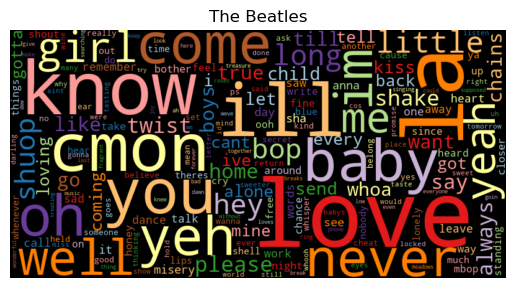

In [17]:
beatles_count = count_words(beatles)
wordcloud(beatles_count['freq'], title="The Beatles")

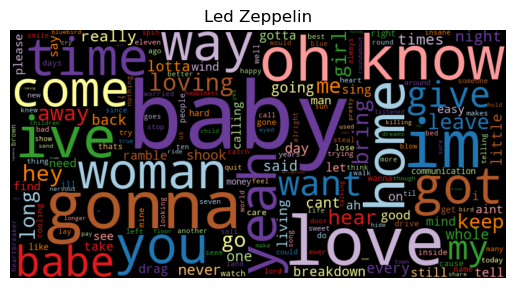

In [18]:
ledzep_count = count_words(ledzep)
wordcloud(ledzep_count['freq'], title="Led Zeppelin")

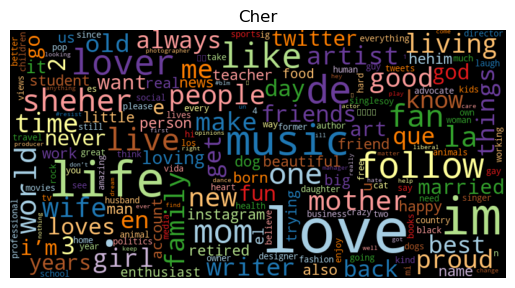

In [19]:
cher_count = count_words(cher)
cher_count = cher_count.drop(index = ('nan'))
wordcloud(cher_count['freq'], title= "Cher")

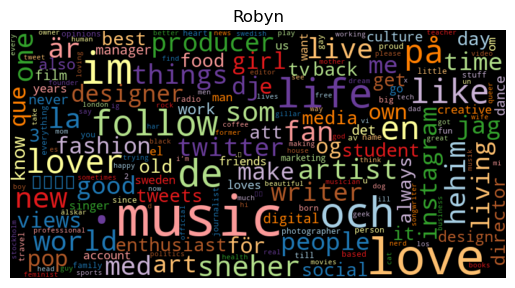

In [29]:
rob_count = count_words(rob)
rob_count = rob_count.drop(index = ('nan'))
wordcloud(rob_count['freq'], title = "Robyn")

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Based on all four wordclouds, we see a reoccuring theme, love is a very common theme throughout music. Between lyrics and descriptions, love was one of the most common words in each of the corpora. We also see this theme continue in the lyrics, with "babe" and "baby" being common terms. For the descriptions, we can see terms that are very common throughout Twitter, such as pronouns 'sheher' and 'hehim' as well as 'follow and 'instagram'. There are also a lot of professions in each of the description clouds. For example, we can see "teacher" and "writer" within Cher's cloud and "dj" and "artist" within" Robyn's cloud. 